In [107]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer

In [108]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [109]:
x = df['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
x

0      0
1      1
2      0
3      1
4      0
5      0
6      1
7      0
8      0
9      0
10     1
11     1
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     1
22     0
23     1
24     0
25     0
26     0
27     1
28     0
29     0
      ..
861    0
862    1
863    0
864    0
865    0
866    0
867    1
868    0
869    0
870    0
871    1
872    1
873    0
874    0
875    0
876    0
877    0
878    0
879    1
880    0
881    0
882    0
883    0
884    0
885    0
886    0
887    1
888    0
889    1
890    0
Name: Cabin, dtype: int64

In [110]:
def has_family(df):
    return (df['SibSp'] + df['Parch'] > 0).to_frame().astype(int)
    
def has_cabin(df):
    return df['Cabin'].apply(lambda x: 0 if type(x) == float else 1).to_frame()

def is_child(df):
    return df['Age'].apply(lambda x: 1 if x<18 else 0).to_frame()

def dummies(df):
    return pd.get_dummies(df[['Sex','Embarked', 'Pclass']], drop_first=True)

def base_features(df):
    return df[['Pclass', 'Age','SibSp','Parch','Fare']]

base_features_tf = FunctionTransformer(base_features,validate=False)
dummies_tf = FunctionTransformer(dummies, validate=False)
is_child_tf = FunctionTransformer(is_child, validate=False)
has_cabin_tf = FunctionTransformer(has_cabin, validate=False)
fam_count_tf = FunctionTransformer(has_family, validate=False)

In [111]:
features = FeatureUnion([
    ('base_features', base_features_tf),
    ('dummies', dummies_tf),
    ('is_child', is_child_tf),
    ('has_cabin', has_cabin_tf),
    ('has_family', fam_count_tf)
])

In [112]:
X = features.fit_transform(df)
y = df['Survived']

AttributeError: 'numpy.ndarray' object has no attribute 'to_frame'

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, random_state = 2003)

In [97]:
model = XGBClassifier()

In [98]:
model.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test,y_test)], eval_metric='logloss', verbose=False, early_stopping_rounds=10)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [99]:
model.score(X_test, y_test)

0.82511210762331844

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

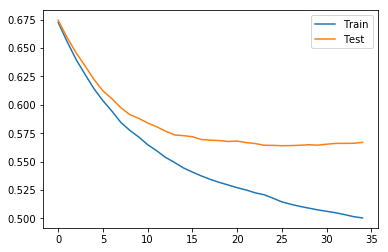

In [47]:
plt.plot(model.evals_result_['validation_0']['logloss'], label='Train')
plt.plot(model.evals_result_['validation_1']['logloss'], label='Test')

plt.legend()

In [105]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [106]:
pipe = Pipeline([
    ('features', features),
    ('model', XGBClassifier())
])

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2003)
cross_val_score(pipe, df, df['Survived'], cv=kf).mean()

test = pd.read_csv('test.csv')

pipe.fit(df, df['Survived'])

pred = pipe.predict(test)

test['Survived'] = pred
test[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)